In [1]:
import torch
from PIL import Image
from resources.models import load_model_and_preprocess
import torch, gc
gc.collect()
torch.cuda.empty_cache()



/home/dac/miniconda3/envs/gradcam/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dac/miniconda3/envs/gradcam/lib/python3.11/site-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/home/dac/miniconda3/envs/gradcam/lib/python3.11/site-packages/fairscale/experimental/nn/offload.py:30: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_bwd(orig_func)  # type: ignore


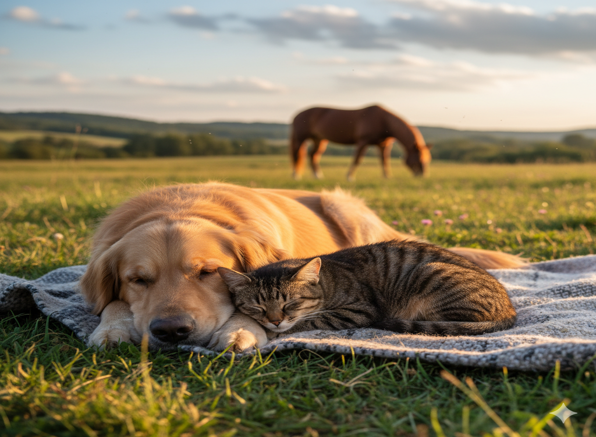

In [2]:
raw_image = Image.open("./imgs/perro_gato_caballo.png").convert("RGB")
display(raw_image.resize((596, 437)))

In [3]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
caption = "a dog and a cat on grass and a horse in the background."

In [4]:
model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "base", device=device, is_eval=True)


/home/dac/miniconda3/envs/gradcam/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
from matplotlib import pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import numpy as np

dst_w = 720
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255

In [6]:
img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
txt = text_processors["eval"](caption)

In [7]:
txt_tokens = model.tokenizer(txt, return_tensors="pt").to(device)
gradcam, _ = compute_gradcam(model, img, txt, txt_tokens, block_num=7)

In [8]:
avg_gradcam = getAttMap(norm_img, gradcam[0][1].detach().cpu().numpy(), blur=True)


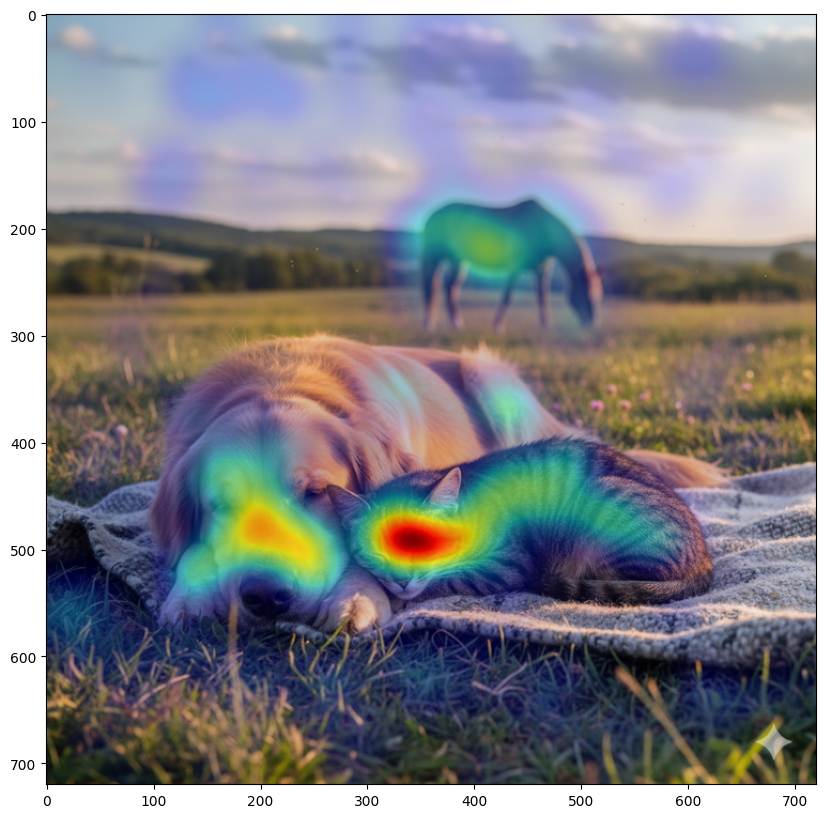

In [9]:
# fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(avg_gradcam)


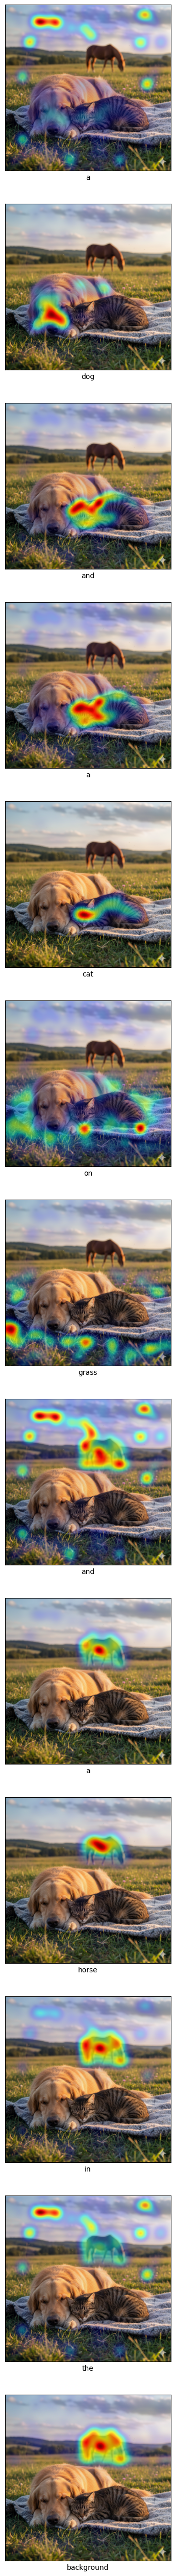

In [10]:
num_image = len(txt_tokens.input_ids[0]) - 2
fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

gradcam_iter = iter(gradcam[0][2:-1])
token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
    word = model.tokenizer.decode([token_id])
    # Convert the gradcam tensor to a numpy array before passing to getAttMap
    gradcam_np = gradcam.detach().cpu().numpy()
    gradcam_image = getAttMap(norm_img, gradcam_np, blur=True)
    ax[i].imshow(gradcam_image)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_xlabel(word)
    